In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
default_train = pd.read_parquet('https://github.com/AlexKbit/stepik-ds-course/raw/master/Week5/SparkML/Project/train.parquet')

In [4]:
default_train

,ad_id,target_audience_count,has_video,is_cpm,is_cpc,ad_cost,day_count,ctr
0,1,10707.244006,1,1,0,201.829293,15,0.431740
1,5,10643.387265,1,1,0,192.577222,15,0.809265
2,6,11418.708591,1,1,0,204.104563,11,0.909738
3,7,10109.327869,1,1,0,194.255799,12,0.941221
4,8,10665.111999,1,1,0,202.658043,14,0.986790
...,...,...,...,...,...,...,...,...
160146,199995,1782.613315,1,1,0,202.212696,13,9.075005
160147,199996,2108.129957,1,1,0,201.072875,15,9.106469
160148,199998,1977.714477,1,1,0,199.999238,17,9.268795
160149,199999,1527.128896,1,1,0,200.309588,16,9.677416


## Lets do some EDA

In [5]:
default_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160151 entries, 0 to 160150
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ad_id                  160151 non-null  int32  
 1   target_audience_count  160151 non-null  float64
 2   has_video              160151 non-null  int32  
 3   is_cpm                 160151 non-null  int32  
 4   is_cpc                 160151 non-null  int32  
 5   ad_cost                160151 non-null  float64
 6   day_count              160151 non-null  int32  
 7   ctr                    160151 non-null  float64
dtypes: float64(3), int32(5)
memory usage: 6.7 MB


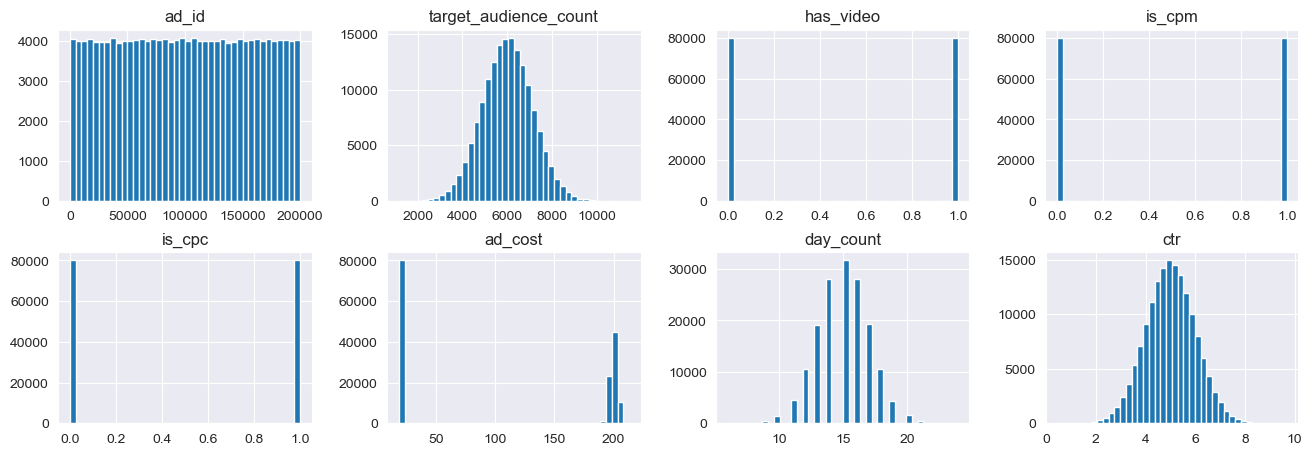

In [8]:
default_train.hist(bins=40, layout=(3,4), figsize=(16,8));

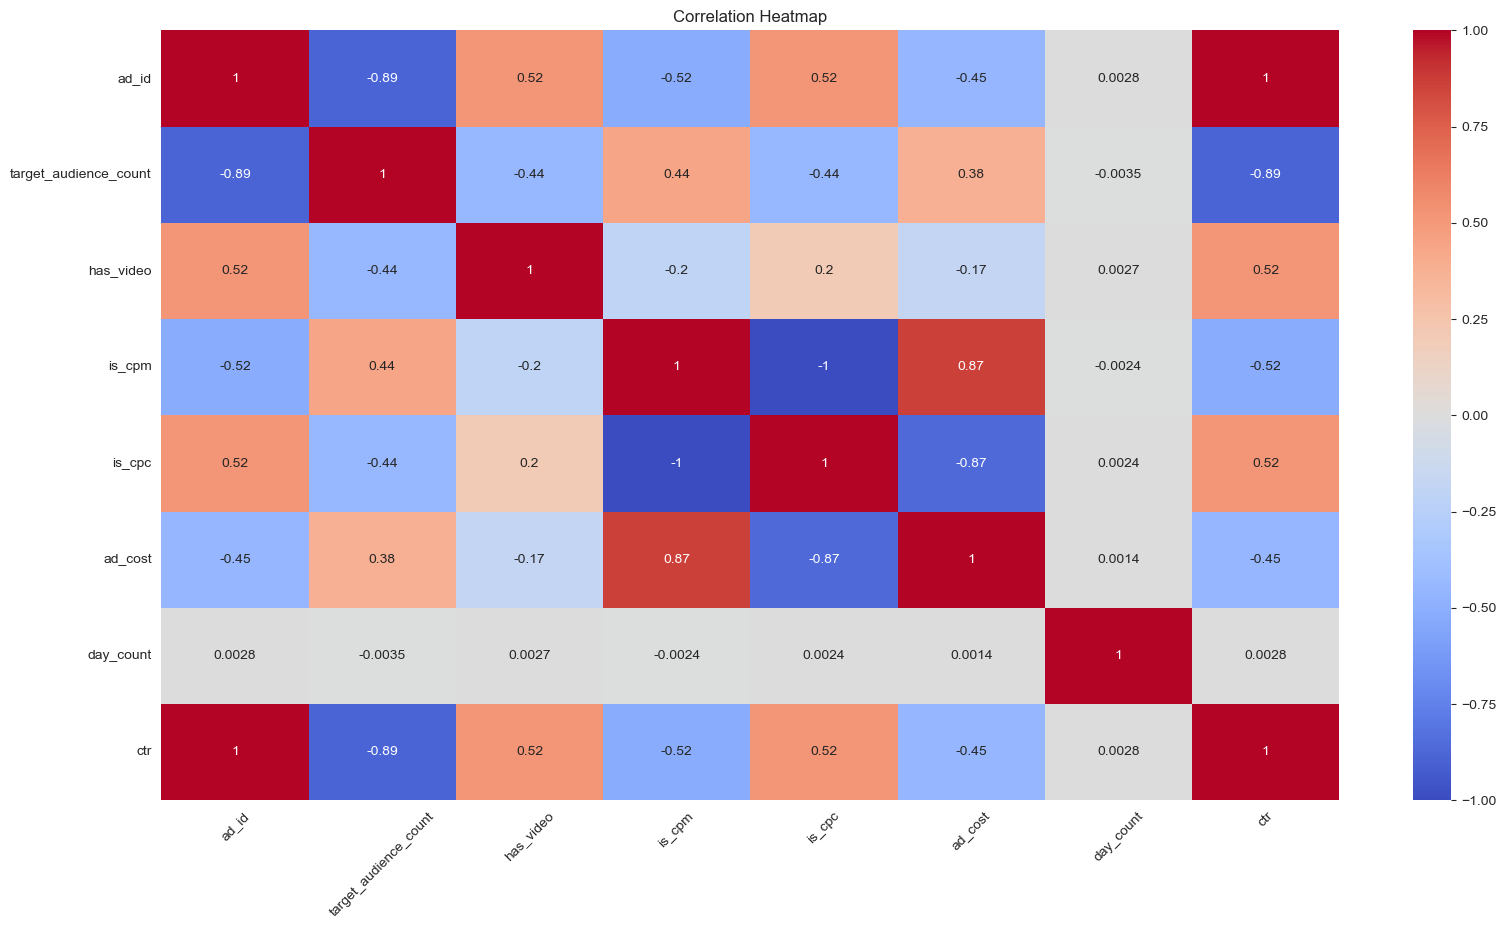

In [91]:
correlation_matrix = default_train.corr(method='spearman')
# top_features = correlation_matrix[abs(correlation_matrix['Price']) > 0.3].index
plt.figure(figsize=(19, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# Настройки для отображения
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Отображение хитмапа
plt.show()

In [82]:

df_checker = default_train.drop([ 'is_cpc' ], axis=1).copy() # отброшу именно её, т.к. напрямую скорелирована с is_cpm и без неё модель показывает лучше результат
# df_checker = default_train.copy()

In [83]:
df_checker['target_audience_count'] = df_checker['target_audience_count'].astype(int)

In [84]:
df_checker

,ad_id,target_audience_count,has_video,is_cpm,ad_cost,day_count,ctr
0,1,10707,1,1,201.829293,15,0.431740
1,5,10643,1,1,192.577222,15,0.809265
2,6,11418,1,1,204.104563,11,0.909738
3,7,10109,1,1,194.255799,12,0.941221
4,8,10665,1,1,202.658043,14,0.986790
...,...,...,...,...,...,...,...
160146,199995,1782,1,1,202.212696,13,9.075005
160147,199996,2108,1,1,201.072875,15,9.106469
160148,199998,1977,1,1,199.999238,17,9.268795
160149,199999,1527,1,1,200.309588,16,9.677416


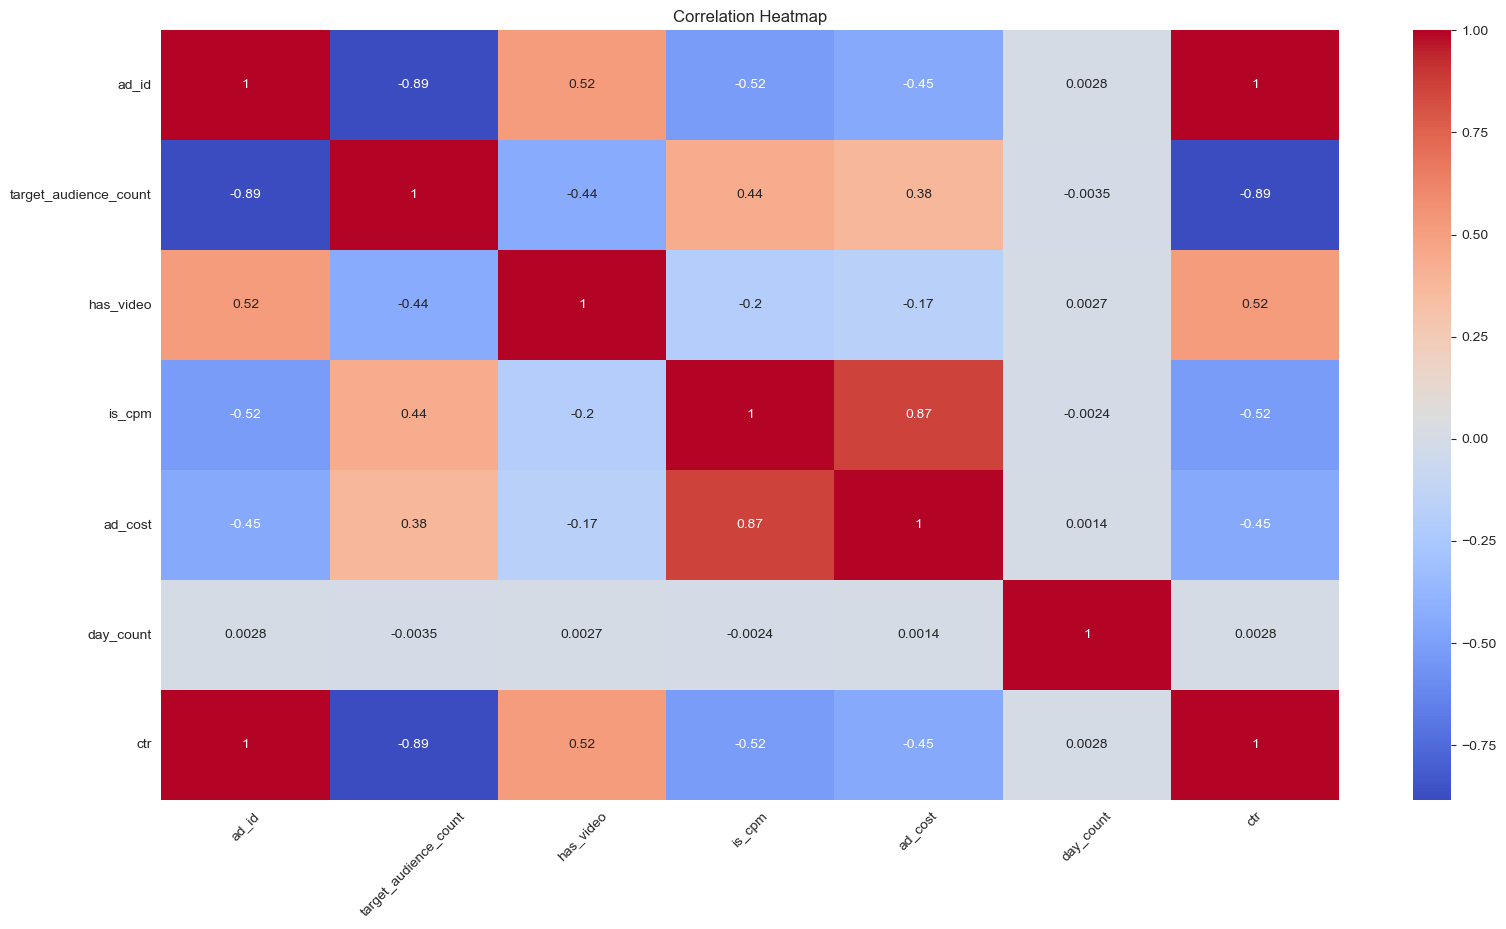

In [92]:
correlation_matrix = df_checker.corr(method='spearman')
# top_features = correlation_matrix[abs(correlation_matrix['Price']) > 0.3].index
plt.figure(figsize=(19, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# Настройки для отображения
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Отображение хитмапа
plt.show()

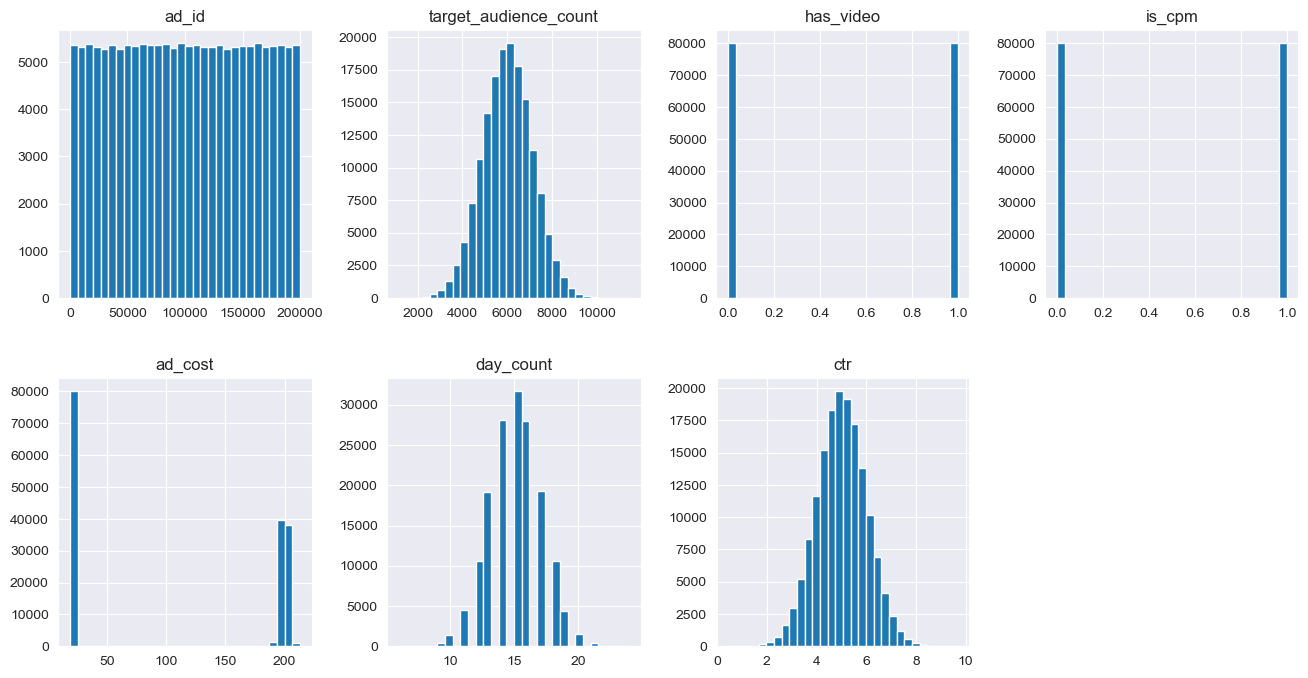

In [90]:
df_checker.hist(bins=30, layout=(2,4), figsize=(16,8));

In [70]:
# df_checker['target_audience_count_x2'] = df_checker['target_audience_count'] ** 2
# df_checker['target_audience_count_sqrt'] = df_checker['target_audience_count'] ** 0.5
# df_checker['target_audience_count_log'] = np.log(df_checker['target_audience_count_sqrt'])
# df_checker['target_audience_count_sqrt_/_target_audience_count_x2'] = df_checker['target_audience_count_sqrt'] / df_checker['target_audience_count_x2']
# df_checker['target_audience_count_sqrt_/_target_audience_count'] = df_checker['target_audience_count_sqrt'] / df_checker['target_audience_count']

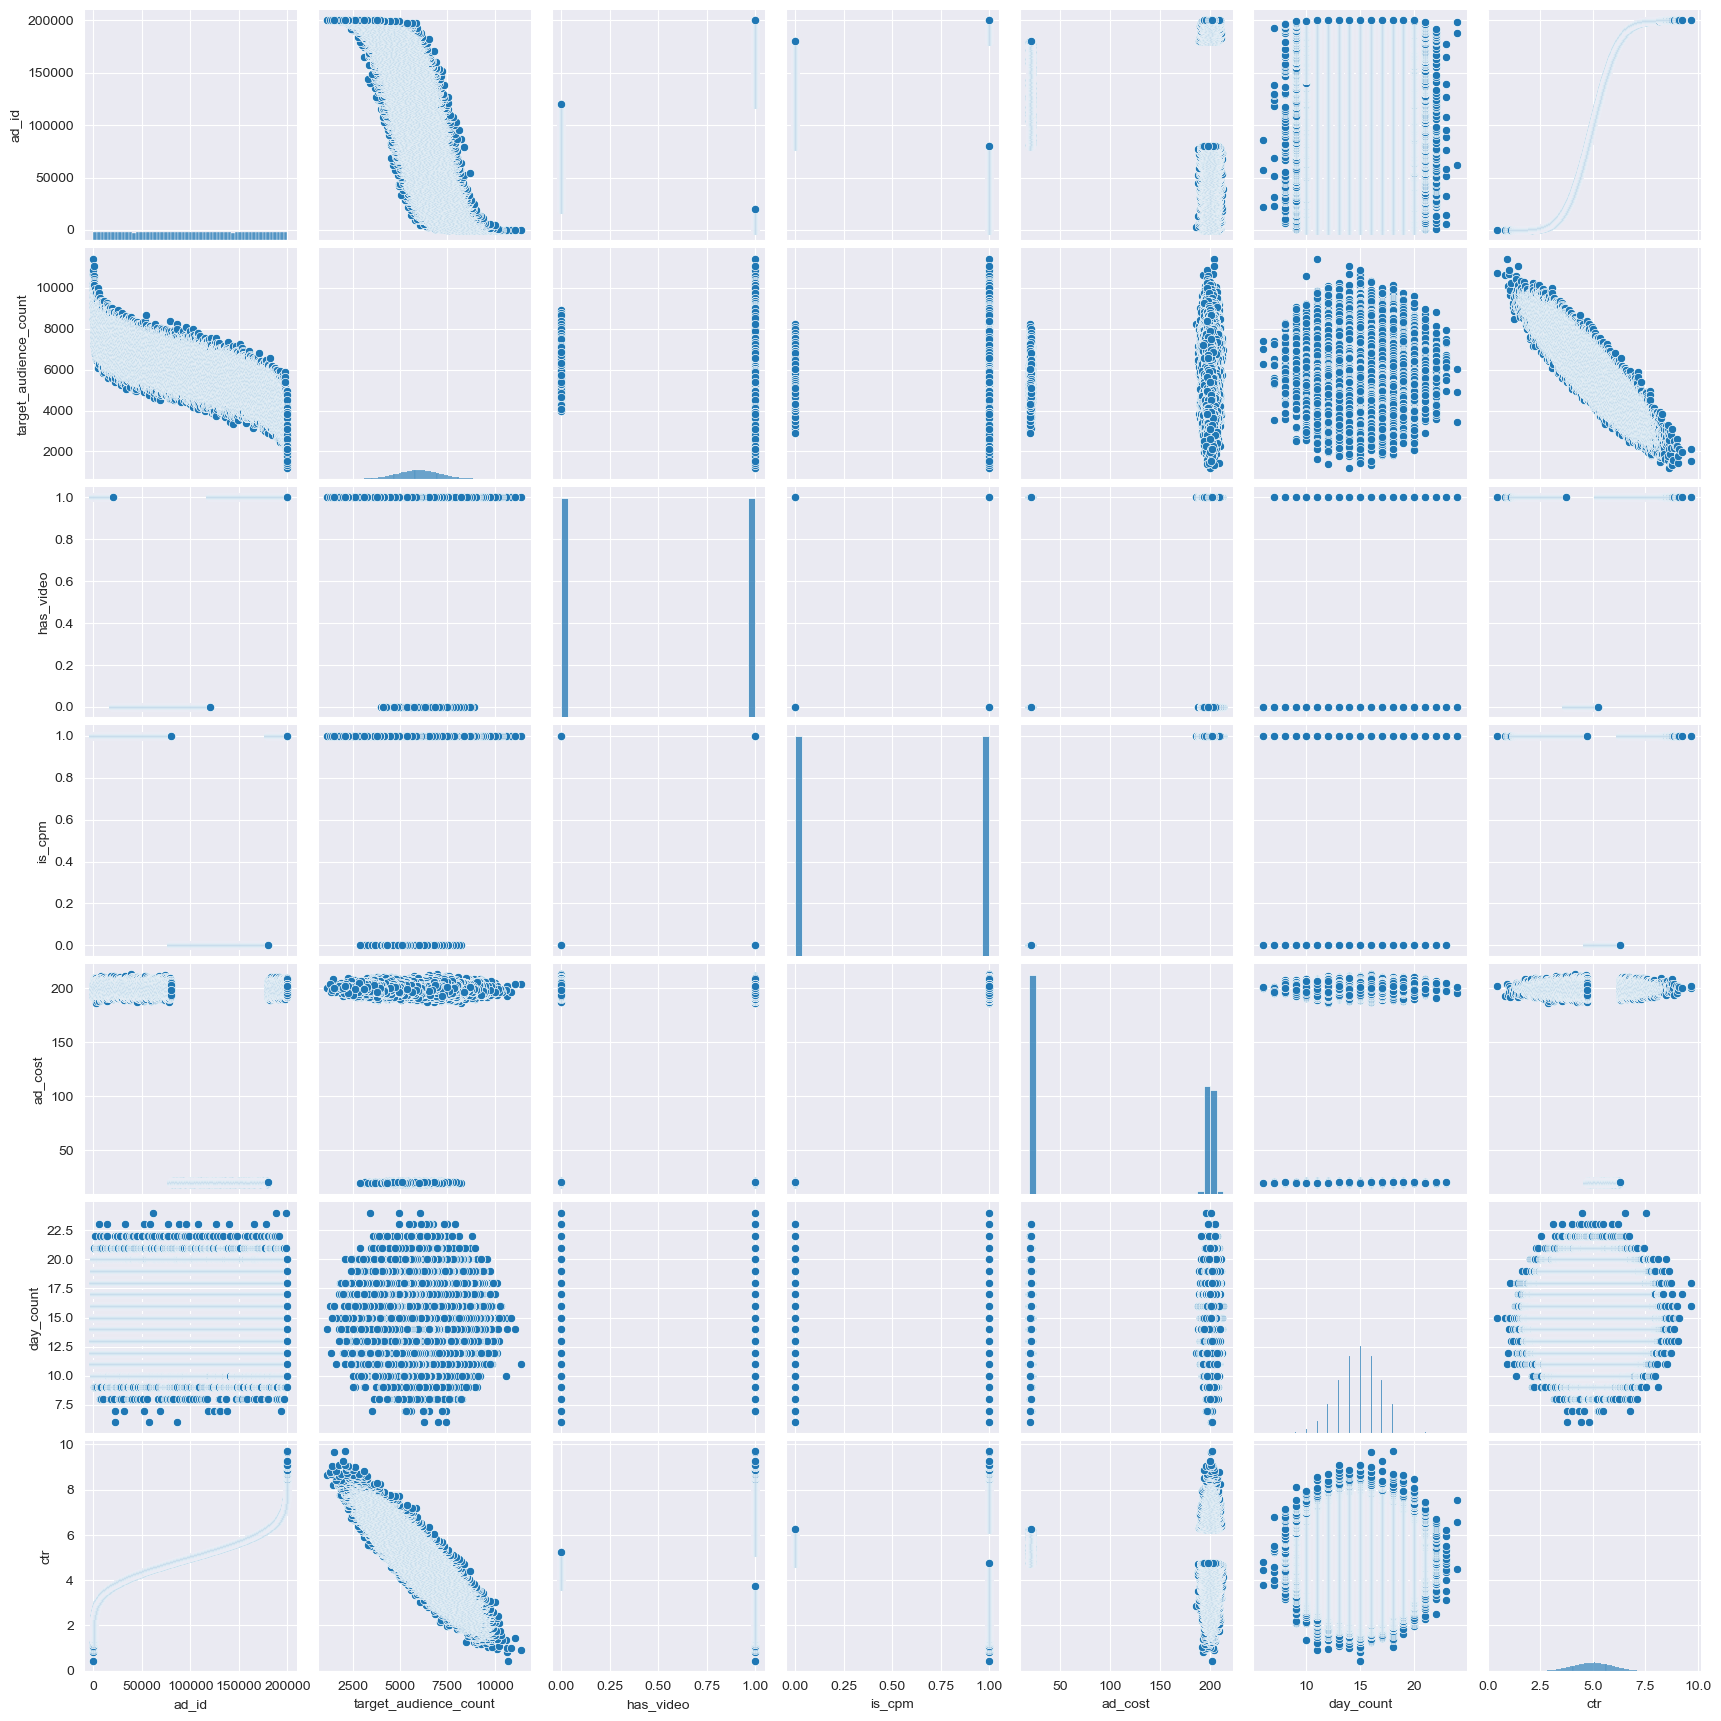

In [93]:
sns.pairplot(df_checker)
plt.show()

In [72]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [73]:
df_checker

,ad_id,target_audience_count,has_video,is_cpm,ad_cost,ctr
0,1,10707,1,1,201.829293,0.431740
1,5,10643,1,1,192.577222,0.809265
2,6,11418,1,1,204.104563,0.909738
3,7,10109,1,1,194.255799,0.941221
4,8,10665,1,1,202.658043,0.986790
...,...,...,...,...,...,...
160146,199995,1782,1,1,202.212696,9.075005
160147,199996,2108,1,1,201.072875,9.106469
160148,199998,1977,1,1,199.999238,9.268795
160149,199999,1527,1,1,200.309588,9.677416


In [85]:
X = df_checker.drop('ctr', axis=1)
# X = df_checker[important_features_005]

Y = df_checker['ctr']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)

In [86]:
"""-= OPTUNA =-"""
# %%time
#
# Создаем функцию для оптимизации
# def objective(trial):
#     # Задаем пространство гиперпараметров
#     param = {
#         'objective': 'regression',
#         'metric': 'l2',
#         'verbosity': -1,
#         'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
#         'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 900, 3000),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'max_depth': trial.suggest_int('max_depth', 5, 80),
#         'lambda_l1': trial.suggest_int('lambda_l1', 0.0, 7.0),
#         'lambda_l2': trial.suggest_int('lambda_l2', 0.0, 7.0),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
#     }
#
#     # Обучение модели
#     model = lgb.LGBMRegressor(**param)
#     model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=False) # , early_stopping_rounds=80
#
#     # Предсказание и расчет метрики
#     preds = model.predict(X_test)
#     error = sqrt(mean_squared_error(Y_test, preds))
#
#     return error
#
# # Создаем объект study и ищем оптимальные гиперпараметры
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=15)
#
# # Выводим наилучшие параметры
# print('Best trial:')
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

'-= OPTUNA =-'

In [87]:
"""= LGBM_param_grid ="""
LGBM_param_grid = {
    # 'boosting_type': ['gbdt'],
    # 'num_leaves': [ 16 ],
    # 'learning_rate': [ 0.0038653677565222565 ],
    # 'n_estimators': [ 2720 ],
    # 'min_child_samples': [ 59 ],
    # 'max_depth': [ 49 ],
    # 'lambda_l1': [6],
    # 'lambda_l2': [4],
    # 'feature_fraction': [0.8526219644845056]

    'boosting_type': ['goss'], # при разделении тренировочного датасета на трейн и тест
    'num_leaves': [ 23 ],
    'learning_rate': [ 0.002785476205094045 ],
    'n_estimators': [ 2152 ],
    'min_child_samples': [ 44 ],
    'max_depth': [ 26 ],
    'lambda_l1': [7],
    'lambda_l2': [5],
    'feature_fraction': [0.9743395311008133]
}

In [88]:
"""= GridSearchCV ="""
# %%time
LGBMC_optimal_params = lgb.LGBMRegressor(
    objective='regression',
    seed=42,
    subsample=0.95,
    colsample_bytree=0.85,
)

LGBMC_optimal_params_cv = GridSearchCV( estimator=LGBMC_optimal_params,
                                        param_grid=LGBM_param_grid,
                                        scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
                                        verbose=2,
                                        n_jobs=-1,
                                        cv=5
                                        )

LGBMC_optimal_params_cv.fit(X_train,
                            Y_train,
                            eval_set=[(X_test, Y_test)],
                            verbose=False
                            )

cv_results_df = pd.DataFrame(LGBMC_optimal_params_cv.cv_results_)

print('Best params:', LGBMC_optimal_params_cv.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Rost\anaconda3\envs\workspace\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9743395311008133, colsample_bytree=0.85 will be ignored. Current value: feature_fraction=0.9743395311008133
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
Best params: {'boosting_type': 'goss', 'feature_fraction': 0.9743395311008133, 'lambda_l1': 7, 'lambda_l2': 5, 'learning_rate': 0.002785476205094045, 'max_depth': 26, 'min_child_samples': 44, 'n_estimators': 2152, 'num_leaves': 23}


In [89]:
from sklearn.metrics import mean_squared_error
from math import sqrt

LGBM_best_model = lgb.LGBMRegressor(**LGBMC_optimal_params_cv.best_params_)
LGBM_best_model.fit(X_train, Y_train)

# calculate RMSE of the best model
Y_pred = LGBM_best_model.predict(X_test)
RMSE = sqrt(mean_squared_error(Y_test, Y_pred))
print('RMSE of the best model:', RMSE)

RMSE of the best model: 0.02670552130096912


In [79]:
print('RMSE of the best model:', RMSE)

RMSE of the best model: 0.026713584684626916


In [80]:
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt

# Вычислите важности признаков с помощью permutation_importance
result = permutation_importance(LGBM_best_model, X_test, Y_test, n_repeats=10, random_state=42)

# Получите индексы важности признаков, отсортированные в порядке убывания важности
sorted_idx = result.importances_mean.argsort()

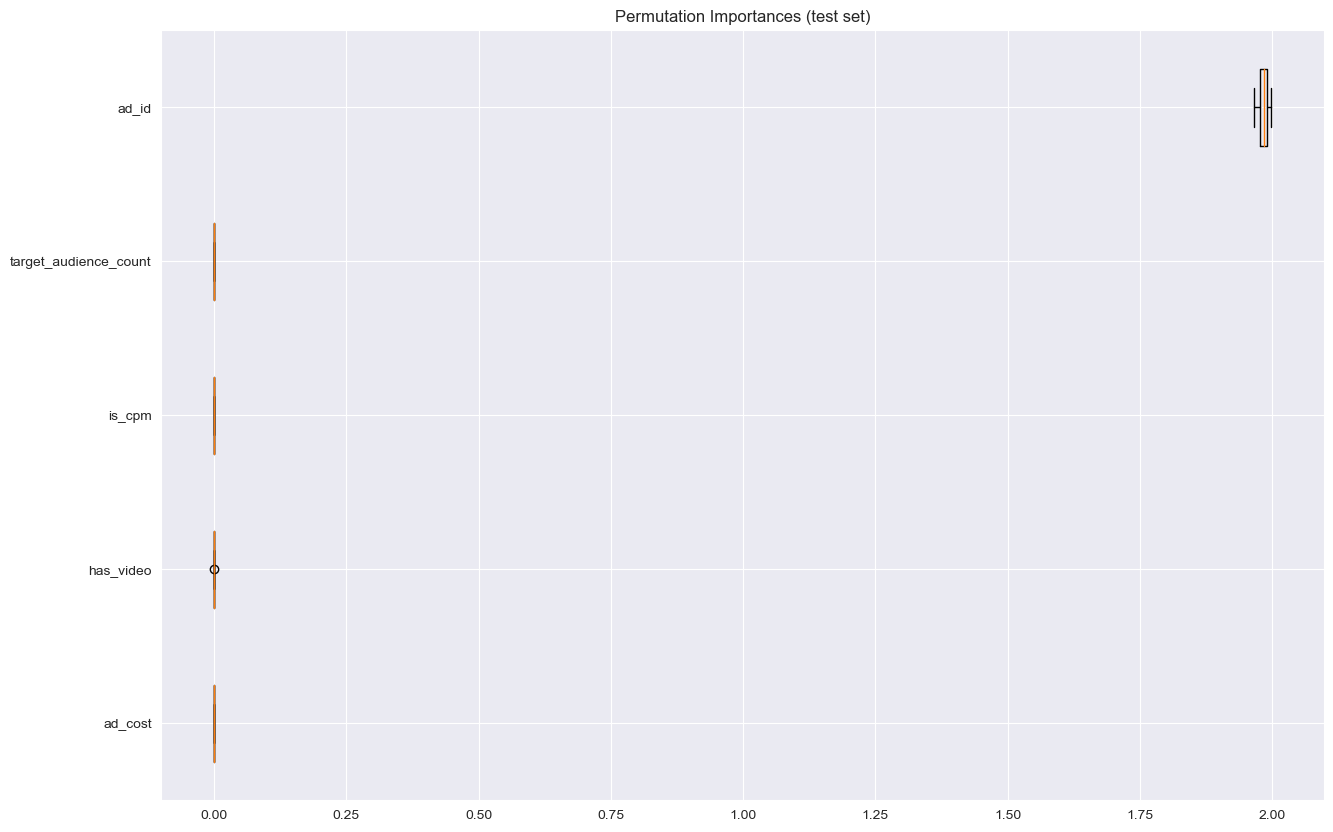

CPU times: total: 1.05 s
Wall time: 214 ms


In [81]:
%%time
plt.figure(figsize=(15, 10))
# Визуализируйте важность признаков
plt.boxplot(result.importances[sorted_idx].T,
            vert=False,
            labels=X_test.columns[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.show()

In [271]:
threshold = 0.2

X_test_temp = X_test.copy()

# Получите признаки с важностью выше порога
important_features_005 = X_test_temp.columns[result.importances_mean > threshold]

important_features_005

Index(['target_audience_count', 'has_video', 'is_cpm'], dtype='object')

In [27]:
default_test = pd.read_parquet('https://github.com/AlexKbit/stepik-ds-course/raw/master/Week5/SparkML/Project/test.parquet')

In [28]:

df_test = default_test.drop([  'day_count', 'is_cpc'], axis=1).copy()


In [29]:
df_test['target_audience_count'] = df_test['target_audience_count'].astype(int)

In [30]:
df_test

,ad_id,target_audience_count,has_video,is_cpm,ad_cost,ctr
0,2,11012,1,1,196.691892,0.500051
1,3,9923,1,1,202.617039,0.637132
2,4,10202,1,1,203.496891,0.783706
3,10,10239,1,1,195.804239,1.010446
4,13,8373,1,1,202.221615,1.055703
...,...,...,...,...,...,...
39844,199962,2860,1,1,199.497656,8.556444
39845,199979,1940,1,1,204.164527,8.702263
39846,199982,1140,1,1,195.476057,8.721238
39847,199987,2140,1,1,200.027993,8.811599


In [31]:
X_test_test = df_test.drop('ctr', axis=1)
# X_val = df_val[['target_audience_count', 'has_video']]

Y_test_test = df_test['ctr']

In [32]:
# calculate RMSE of the best model
Y_pred = LGBM_best_model.predict(X_test_test)
RMSE = sqrt(mean_squared_error(Y_test_test, Y_pred))
print('RMSE of the best model:', RMSE)

RMSE of the best model: 0.02796564282441129


In [64]:
print('RMSE of the best model:', RMSE)

RMSE of the best model: 0.02670552130096912


# заметки

In [ ]:
что меня удивило - так это прямая зависимость целевой переменной от айдишника. без айдишника rmse не получить лучше 0.24, но стоит вернуть колонку с айди и вуаля 0.026 - улучшение на порядок!